<a href="https://colab.research.google.com/github/PencilMario/stable-diffusion-webui/blob/master/StableDiffusionUI_(adapted_to_NovelAILeaks).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# StableDiffusionWebui 训练自动保存版v20221017
基于笔记本https://github.com/JingShing/novelai-colab-ver/blob/main/webui-ver/StableDiffusionUI_(adapted_to_NovelAILeaks).ipynb 修改而成

主要在跑训练时自动将训练结果保存至google drive, 如果你真的想用这个跑图也是可以的

本记事本可以在https://github.com/PencilMario/stable-diffusion-webui/blob/master/StableDiffusionUI_(adapted_to_NovelAILeaks).ipynb 获取最新版本

enjoy~

> 模型保存位置：`StableDiffusionTraining`  
> loss分析表格位置：`StableDiffusionTraining/log/模型名称文件夹`  

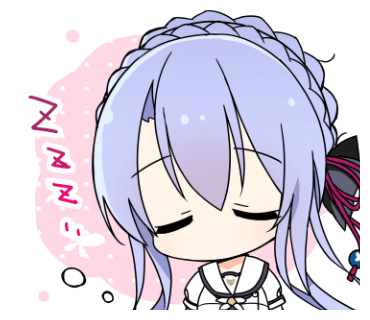

#预处理

In [ ]:
#@title 工具函数
#@markdown 在运行以下指令块前请先运行这个
import subprocess
def run_command_by_line(command_args):
    def print_pipe(raw):
        return print(raw.decode("utf-8"), end='')
    with subprocess.Popen(command_args, stdout=subprocess.PIPE, stderr=subprocess.PIPE) as process:
      while process.poll() is None:
        print_pipe(process.stdout.readline())
      [print_pipe(line) for line in process.stderr.readlines()]
    return

def check_select(str, instr):
  strs="qwertyuiopasdfghjklzxcvbnm"
  str=str.lower()
  result=[]
  for i in strs:
    if str.find(i) != -1:
      result.append(i)
  for a in result:
    if a==instr:
      return True
  return False



In [ ]:
#@title 挂载Google Drive
#@markdown **警告：可能会导致Google扫描你的网盘，建议在干净的网盘账号上使用，以防万一:)**
#@markdown > 如果你不需要训练风格模型，即只用来跑图，那么不需要挂载谷歌网盘，直接运行下一个语句块即可。

#@markdown 训练时的模型和预览图将被保存到谷歌网盘的`StableDiffusionTraining`文件夹

#@markdown *小提示：colab的根目录是/content*  
#@markdown *如：sample_data在程序内的目录是/content/sample_data*
#@markdown 
#@markdown *小提示2：训练模型时保存单独的 log 文件夹，有助于分析模型训练状态*
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
#@title clone webui仓库
%cd /content/
!git clone https://github.com/PencilMario/stable-diffusion-webui
%cd stable-diffusion-webui

/content
Cloning into 'stable-diffusion-webui'...
remote: Enumerating objects: 6778, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 6778 (delta 5), reused 9 (delta 5), pack-reused 6765
Receiving objects: 100% (6778/6778), 21.73 MiB | 45.42 MiB/s, done.
Resolving deltas: 100% (4794/4794), done.
/content/stable-diffusion-webui


In [ ]:
#@title 从NovelAlLeaks下载模型
#@markdown 输入指定的字符将会下载对应模型
#@markdown
#@markdown a - *7G animefull-final-latest （可能不工作)*
#@markdown 
#@markdown b - *4G animefull-final-pruned*
#@markdown
#@markdown c - *4G animefull-final-pruned （备用链接 | 推荐）*
#@markdown
#@markdown d - *hpyernetworks 全局风格模型文件*
#@markdown 
#@markdown e - *7G animefull-latest 可能对训练有所帮助|OneDrive*
#@markdown

#@markdown > 如果什么都不填，相当于填入c, ab从谷歌网盘下载，当人数过多时可能无法下载 

下载模型文件 = "e" #@param {type:"string"}
为每个模型下载权重文件 = True #@param {type:"boolean"}
!mkdir -p /content/stable-diffusion-webui/models/Stable-diffusion /content/stable-diffusion-webui/models/hypernetworks
%cd /content/stable-diffusion-webui/models/Stable-diffusion/
if check_select(下载模型文件, 'a'):
  !gdown 17WWd6KEsBj7D_0TyGp8aXHQDlchYVs1a -O /content/stable-diffusion-webui/models/Stable-diffusion/animefull-final-latest.ckpt
  if 为每个模型下载权重文件:
    !curl -Lo animefull-final-latest.vae.pt https://cloudflare-ipfs.com/ipfs/bafybeiccldswdd3wvg57jhclcq53lvsc6gizasiblwayvhlv6eq4wow7wu/animevae.pt 
if check_select(下载模型文件, 'b'):
  !gdown 1d3f2fvN2gLRocBahZrXe_v1EEHuqpUzT -O /content/stable-diffusion-webui/models/Stable-diffusion/animefull-final-pruned.ckpt
  if 为每个模型下载权重文件:
    !curl -Lo animefull-final-pruned.vae.pt https://cloudflare-ipfs.com/ipfs/bafybeiccldswdd3wvg57jhclcq53lvsc6gizasiblwayvhlv6eq4wow7wu/animevae.pt 

if check_select(下载模型文件, 'c'):
  !curl -Lo animefull-final-pruned.ckpt https://cloudflare-ipfs.com/ipfs/bafybeicpamreyp2bsocyk3hpxr7ixb2g2rnrequub3j2ahrkdxbvfbvjc4/model.ckpt
  if 为每个模型下载权重文件:
    !curl -Lo animefull-final-pruned.vae.pt https://cloudflare-ipfs.com/ipfs/bafybeiccldswdd3wvg57jhclcq53lvsc6gizasiblwayvhlv6eq4wow7wu/animevae.pt 

if check_select(下载模型文件, 'd'):
  !curl -L https://cloudflare-ipfs.com/ipfs/bafybeiduanx2b3mcvxlwr66igcwnpfmk3nc3qgxlpwh6oq6m6pxii3f77e/_modules.tar | tar x -C /content/stable-diffusion-webui/models/hypernetworks

if check_select(下载模型文件, 'e'):
  !curl -Lo animefull-latest.ckpt https://link.jscdn.cn/1drv/aHR0cHM6Ly8xZHJ2Lm1zL3UvcyFBdXhYOTVIVGRJNkxtVjA4dkRTZjdNdE92MGpuP2U9d2xNYTl2.jpg
  if 为每个模型下载权重文件:
    !curl -Lo animefull-latest.vae.pt https://cloudflare-ipfs.com/ipfs/bafybeiccldswdd3wvg57jhclcq53lvsc6gizasiblwayvhlv6eq4wow7wu/animevae.pt 

if 下载模型文件 is None:
  run_command_by_line(['curl','-Lo','model.ckpt','https://cloudflare-ipfs.com/ipfs/bafybeicpamreyp2bsocyk3hpxr7ixb2g2rnrequub3j2ahrkdxbvfbvjc4/model.ckpt'])
  if 为每个模型下载权重文件:
    !curl -Lo model.vae.pt https://cloudflare-ipfs.com/ipfs/bafybeiccldswdd3wvg57jhclcq53lvsc6gizasiblwayvhlv6eq4wow7wu/animevae.pt 
print("下载完成")

/content/stable-diffusion-webui/models/Stable-diffusion
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4067M  100 4067M    0     0  84.5M      0  0:00:48  0:00:48 --:--:-- 91.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  784M  100  784M    0     0  65.1M      0  0:00:12  0:00:12 --:--:-- 64.2M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1004M  100 1004M    0     0  65.1M      0  0:00:15  0:00:15 --:--:-- 72.4M
下载完成


#运行sd-webui


In [ ]:
#@markdown 启动webui。你将得到一个***.gradio.app的链接

#@markdown 启动项参数：

#@markdown `--share` - 创建在线gradio.app链接
#@markdown 
#@markdown `--gradio-debug` - 打印输出到控制台
#@markdown 
#@markdown `--gradio-auth me:qwerty` - 登录验证：用户名me，密码qwerty
#@markdown 
#@markdown `--deepdanbooru` - 支持使用deepdanbooru进行数据集预处理,
#@markdown 
#@markdown `--skip-torch-cuda-test` 跳过GPU检测，用于测试
%cd /content/stable-diffusion-webui
CMD = "COMMANDLINE_ARGS"
REQFILE="REQS_FILE"
#@markdown ----------
启动项 = "--share --gradio-debug --deepdanbooru --skip-torch-cuda-test" #@param{type:"string"}

依赖文件 = "requirements.txt" #@param {type:"string"}
RUN = "python launch.py"
import os
os.environ[CMD] = 启动项
os.environ[REQFILE] = 依赖文件

!python launch.py

/content/stable-diffusion-webui
Python 3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]
Commit hash: fae2ec021e3e23880de70c3d1a04c4ad426402e4
Installing requirements for Web UI
Launching Web UI with arguments: --share --gradio-debug --deepdanbooru
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loading weights [925997e9] from /content/stable-diffusion-webui/models/Stable-diffusion/animefull-final-pruned.ckpt
Loading VAE weights from: /content/stable-diffusion-webui/models/Stable-diffusion/animefull-final-pruned.vae.pt
Applying cross attention optimization (Doggettx).
Model loaded.
Loaded a total of 1 textual inversion embeddings.
Embeddings: t2
Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://52c5896ee4e7a081.gradio.app

This share link expires in 72 

#工具
建议挂载网盘后使用

In [ ]:
#@title 解压文件
#@markdown .zip文件路径  
filename = "/content/drive/MyDrive/sample.zip" #@param
#@markdown 解压至文件夹
outpath = "/content/extract_files" #@param

import os
os.makedirs(outpath,exist_ok=True)
#@markdown ~~没成功就再试一遍~~
run_command_by_line(["7z", 'x', filename, "-o"+outpath if outpath[-1]!="/" else "-o"+outpath+"/"])

In [ ]:
#@title 更新sd(用于测试)
%cd /content/stable-diffusion-webui
!git pull

/content/stable-diffusion-webui
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/PencilMario/stable-diffusion-webui
   c450437..fae2ec0  master     -> origin/master
Updating c450437..fae2ec0
Fast-forward
 modules/sptools.py | 29 +++++++++++++++--------------
 1 file changed, 15 insertions(+), 14 deletions(-)


In [ ]:
#@title 删除sd（用于测试）
import shutil 
shutil.rmtree("/content/stable-diffusion-webui")

#杂项

*以下语句块只有在**#运行sd-webui**结束后才建议使用*

In [ ]:
#@title 保存生成的图片

!zip -r /content/stable-diffusion-webui /content/stable-diffusion-webui/outputs 

In [ ]:
#@title 保存图片到谷歌drive
#@markdown **警告：可能会导致Google扫描你的网盘，建议在干净的网盘账号上使用，以防万一:)**
from google.colab import drive # type: ignore

try:
   drive_path = "/content/drive"
   drive.mount(drive_path,force_remount=False)
except:
   print("...error mounting drive or with drive path variables")

!cp -r "/content/stable-diffusion-webui/outputs" "/content/drive/MyDrive"